# Preprocessing paragraphs and sections

This notebook does 
 - preprocesses each document into two versions:
     - all body sections preprocessed and merged into one text file
     - all body sections preprocessed and listed separately, per document, in a single JSON as in the input dataset
 - preprocessing steps applied
     - tokenization (NLTK)
     - lemmatization (NLTK)
     - n-grams (Gensim)
     - stop-word removal (NLTK based + added some of my own from unrecognized words)
     - punctuation and special characters removal
     - removal of some article templates text, such as copyrights 
 - outputs produced
     - under output/whole/... the preprocessed documents with all body texts in one text file
     - under output/paragraphs/... the processed documents with each original body section separately listed in JSON format
     - output/closest.txt, a list of unrecognized (by dictionary) words and the closest match to known words (using Levenshtein word-distance)
     - output/unknown.txt, list of all unrecognized words sorted by frequency
     - the above output is compressed into output.zip and output.tar.gz for use as kernel input sources

Update April 25th, 2020:
- Update input dataset to Kaggle version from April 24th

Update April 19th, 2020:
- Fixed also filepaths being off similar to doc paths. Was causing downstream notebooks to use wrong input.
- Updated input dataset to Kaggle version from April 17th

Update April 18th, 2020: 
- Added stop word removal before and after lemmatization. NLTK lemmatizer does some weird things (e.g., was->wa, has->ha)
- Fixed saved doc id's being off when docs are removed

I made this notebook to provide input for further kernels to try techniques such as topic models.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

import os

import kaggle_uploader


In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

In [3]:
kaggle_uploader.__version__

'0.3.0'

I use multiprocessing later in the kernel to process much of the data. It help process data faster but also can help manage memory better. Well, I still had troubles with Spacy and had to remove it due to memory issues but anyway. 

The CORES variable simply defines the number of parallel processes spawned later in multiprocessing.

In [4]:
CORES=4

In [5]:
!mkdir output

In [6]:
!ls /kaggle/input/CORD-19-research-challenge/

COVID.DATA.LIC.AGMT.pdf  cord_19_embeddings_4_17  metadata.csv
biorxiv_medrxiv		 custom_license		  metadata.readme
comm_use_subset		 json_schema.txt	  noncomm_use_subset


COVDoc is just a simple data structure to hold different forms of the documens while preprocessing them:

In [7]:
class COVDoc:
    def __init__(self, filepath: str):
        self.doc_id = None
        self.filepath = filepath
        self.lang = None
        self.file_type = None
        self.paragraph_tokens = []
        self.paragraph_texts = []
        self.processed_paragraphs = []
#        self.processed_spacy_paragraphs = []
        self.processed_nltk_paragraphs = []
        
    #load_text is used to lazy-load the actual text when needed
    def load_text(self):
        with open(self.filepath) as f:
            d = json.load(f)
            for paragraph in d["body_text"]:
                self.paragraph_texts.append(paragraph["text"].lower())


Describe doc is a utility function I used to get an initial idea of some of the document data:

In [8]:
import json

def describe_doc(doc_path):
    with open(doc_path) as f:
        d = json.load(f)
        print(d.keys())
        print(f"number of paragraphs: {len(d['body_text'])}")
        print()
        for idx, paragraph in enumerate(d["body_text"]):
            print()
            print(f"section {idx+1}: title=", end="")
            print(f'{paragraph["section"]}: {len(paragraph["text"])} chars')


In [9]:
import nltk, re, string, collections
from nltk.util import ngrams
from nltk.corpus import stopwords
import spacy

In [10]:
df_metadata = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
df_metadata[df_metadata["has_pmc_xml_parse"] == True].head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998.0,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704.0,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125.0,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723.0,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663.0,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


In [11]:
df_metadata.isnull().sum()

cord_uid                           0
sha                            13826
source_x                           0
title                            163
doi                             3346
pmcid                          10562
pubmed_id                      16461
license                            0
abstract                       10519
publish_time                       8
authors                         2526
journal                         5790
Microsoft Academic Paper ID    56402
WHO #Covidence                 55598
has_pdf_parse                      0
has_pmc_xml_parse                  0
full_text_file                  8445
url                              306
dtype: int64

In [12]:
mask = df_metadata["sha"].isnull() & df_metadata["pmcid"].isnull()
dfnulls = df_metadata[mask]
dfnulls.shape

(3313, 18)

In [13]:
df_metadata[df_metadata["full_text_file"].isnull()]

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
207,28wrp74k,NaN,PMC,SARS and Population Health Technology,10.2196/jmir.5.2.e14,PMC1550560,12857670.0,cc-by,The recent global outbreak of SARS (severe acu...,2003-06-30,"Eysenbach, Gunther",J Med Internet Res,NaN,NaN,False,False,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
208,8f0pn321,NaN,PMC,The Internet as a Vehicle to Communicate Healt...,10.2196/jmir.6.1.e8,PMC1550585,15111274.0,cc-by,BACKGROUND: The recent public health risks ari...,2004-03-03,"Kittler, Anne F; Hobbs, John; Volk, Lynn A; Kr...",J Med Internet Res,NaN,NaN,False,False,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
786,g4puurhk,NaN,PMC,Role of nitric oxide in management of acute re...,10.4103/1817-1737.41914,PMC2700444,19561888.0,cc-by,The current mortality rate of patients sufferi...,2008,"Akmal, A. H.; Hasan, Mohd",Ann Thorac Med,NaN,NaN,False,False,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
787,ke0tkpso,NaN,PMC,Avian influenza: The tip of the iceberg,10.4103/1817-1737.43085,PMC2700449,19561900.0,cc-by,"For some years now, we have been living with t...",2008,"Balkhy, Hanan",Ann Thorac Med,NaN,NaN,False,False,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
820,t579ysgl,NaN,PMC,Reading chest radiographs in the critically il...,10.4103/1817-1737.53349,PMC2714572,19641649.0,cc-by,This is part II of two series review of readin...,2009,"Khan, Ali Nawaz; Al-Jahdali, Hamdan; AL-Ghanem...",Ann Thorac Med,NaN,NaN,False,False,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54643,fzq71ghi,NaN,WHO,Coronavirus latest: Trump requests $2.5 billio...,10.1038/d41586-020-00154-w,NaN,NaN,unk,Trump requests emergency funding for coronavir...,2020-03-17,NaN,Nature,2.143542e+09,#2033,False,False,NaN,https://doi.org/10.1038/d41586-020-00154-w
55361,iqr419fp,NaN,PMC,Prediction of Epidemic Spread of the 2019 Nove...,10.3390/ijerph17051679,PMC7084718,32143519.0,cc-by,After the 2019 novel coronavirus (2019-nCoV) o...,2020-03-04,"Fan, Changyu; Liu, Linping; Guo, Wei; Yang, An...",Int J Environ Res Public Health,3.002748e+09,#4088,False,False,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
55603,3auz7gi6,NaN,PMC,"Bacteriophage Based Biosensors: Trends, Outcom...",10.3390/nano10030501,PMC7153619,32168802.0,cc-by,Foodborne pathogens are one of the main concer...,2020-03-11,"Aliakbar Ahovan, Zahra; Hashemi, Ali; De Plano...",Nanomaterials (Basel),NaN,#8339,False,False,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
56029,ush6iqk5,NaN,PMC,All roads lead to coronavirus,10.1177/0141076820911516,PMC7068761,32160122.0,unk,NaN,2020-03-01,"Abbasi, Kamran",Journal of the Royal Society of Medicine,NaN,#7583,False,False,NaN,https://journals.sagepub.com/doi/pdf/10.1177/0...


In [14]:
df_metadata.shape

(57366, 18)

In [15]:
df_metadata["full_text_file"].unique()

array(['custom_license', 'comm_use_subset', nan, 'noncomm_use_subset',
       'biorxiv_medrxiv'], dtype=object)

## Loading documents, selecting PDF vs PMC

Load the documents from the given path. Processing sequence:

- Read a list of all PDF based JSON files
- Parse file SHA from the filenames
- Check metadata if there is an entry for that SHA
- If the SHA is there, read the PMC XML JSON content instead. It should be better quality.
- If SHA or PMC ID not found, read the PDF JSON and use that


In [16]:
def load_docs_(base_path, file_type):
    if not base_path.endswith("/"):
        base_path = base_path + "/"
    loaded_docs = []
    count_pdf = 0
    count_pmc = 0
    file_paths_pdf = glob.glob(base_path+"pdf_json/*.json")
    file_paths_pmc = glob.glob(base_path+"pmc_json/*.json")
    file_names_pdf = [os.path.basename(path) for path in file_paths_pdf]
    for filepath in tqdm(file_paths_pdf):
        filename_sha = os.path.basename(filepath).split(".")[0]
        #print(filename_sha)
        df_sha = df_metadata[df_metadata["sha"] == filename_sha]
        if df_sha.shape[0] > 0:
            has_pmc = df_sha["has_pmc_xml_parse"].to_list()[0]
            if has_pmc:
                count_pmc += 1
                pmc_id = df_sha["pmcid"].to_list()[0]
                filepath = f"{base_path}pmc_json/{pmc_id}.xml.json"
            else:
                count_pdf += 1
        else:
            count_pdf += 1
        doc = COVDoc(filepath)
        doc.file_type = file_type
        loaded_docs.append(doc)
    print(f"loaded {count_pdf} PDF files, {count_pmc} PMC files of type {file_type}")
    return loaded_docs

In [17]:
file_paths_pdf_all = []
file_paths_pmc_all = []
all_docs = []

def load_doc_paths(base_path, file_type):
    if not base_path.endswith("/"):
        base_path = base_path + "/"
    file_paths_pdf = glob.glob(base_path+"pdf_json/*.json")
    file_paths_pmc = glob.glob(base_path+"pmc_json/*.json")
    file_paths_pdf_all.extend(file_paths_pdf)
    file_paths_pmc_all.extend(file_paths_pmc)

In [18]:
medx_basepath = "/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv"
load_doc_paths(medx_basepath, "medx")

In [19]:
comuse_basepath = "/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/"
load_doc_paths(comuse_basepath, "comuse")

In [20]:
custom_basepath = "/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/"
load_doc_paths(custom_basepath, "custom")


In [21]:
noncom_basepath = "/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/"
load_doc_paths(noncom_basepath, "noncom")

In [22]:
len(file_paths_pdf_all)

45941

In [23]:
len(file_paths_pmc_all)

22263

In [24]:
def find_docs_in_metadata():
    pmc_count = 0
    pmc_missed = 0
    pdf_count = 0
    pdf_missed = 0
    missed = 0
    total = 0
    for idx, row in tqdm(df_metadata.iterrows(), total=df_metadata.shape[0]):
        pmcid = row["pmcid"]
        found_path = None
        if isinstance(pmcid, str):
            for filepath in file_paths_pmc_all:
                if pmcid in filepath:
                    found_path = filepath
                    #print(filepath)
                    pmc_count += 1
                    break
            if found_path is None:
                #print(pmcid)
                pmc_missed += 1
        if found_path is None:
            sha = row["sha"]
            if isinstance(sha, str):
                for filepath in file_paths_pdf_all:
                    #print(sha)
                    if sha in filepath:
                        found_path = filepath
                        #print(filepath)
                        pdf_count += 1
                        break
            if found_path is None:
                pdf_missed += 1
        if found_path is None:
            missed += 1
        else:
            doc = COVDoc(filepath)
            filetype = filepath.split("/")[-3]
            doc.file_type = filetype
            doc.doc_id = row.cord_uid
            all_docs.append(doc)
        total += 1
    print(f"finished: pmc={pmc_count}, pdf={pdf_count}, missed={missed}, pmc_missed={pmc_missed}, pdf_missed={pdf_missed}")


In [25]:
for filepath in file_paths_pmc_all:
    if "PMC2114261" in filepath:
        print(filepath)


/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pmc_json/PMC2114261.xml.json


In [26]:
find_docs_in_metadata()


finished: pmc=22282, pdf=21113, missed=13971, pmc_missed=24522, pdf_missed=13971


In [27]:
#for doc in all_docs:
#    if "PMC2114261" in doc.filepath:
#        print(doc.doc_id)
#        print(doc.filepath)
#        doc.load_text()
#        print(doc.paragraph_texts)

In [28]:
df_metadata[df_metadata["cord_uid"] == "4sw25blb"]

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
38130,4sw25blb,67f40427adfd7f712e114a8f5da4a33158fc9f37,PMC,Signal recognition particle-dependent membrane...,NaN,PMC2114261,3458708.0,cc-by-nc-sa,Invariant (Ii) chain is a membrane-spanning pr...,1986-06-01,NaN,J Cell Biol,NaN,NaN,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [29]:
all_docs[0].doc_id

'zjufx4fo'

In [30]:
all_docs[0].filepath

'/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pmc_json/PMC125340.xml.json'

In [31]:
#all_docs[0].load_text()

In [32]:
#all_docs[0].paragraph_texts

# Processing function definitions

I used show_nltk_bigrams_for() to view potential bigrams:

In [33]:
def show_nltk_bigrams_for(docs):
    tokens = []
    for doc in docs:
        for paragraph in doc.paragraph_texts:
            doc_tokens = nltk.word_tokenize(paragraph)
            tokens.extend(doc_tokens)
    bigrams = ngrams(tokens, 2)
    bigram_freq = collections.Counter(bigrams)
    print(bigram_freq.most_common(100))

### Basic preprocessing

Snippets to delete are some template values from the articles. Mainly from the MedX/BioX since I started with those. But these are removed before anything else is done, so further templates would just require adding lines here:

In [34]:
snippets_to_delete = [
    "The copyright holder for this preprint",
    "doi: medRxiv preprint",
    "doi: bioRxiv preprint",
    "medRxiv preprint",
    "bioRxiv preprint",
    "cc-by-nc-nd 4.0",
    "cc-by-nd 4.0",
    "cc-by-nc 4.0",
    "cc-by 4.0", 
    "international license", 
    "is made available under a",
    "(which was not peer-reviewed)",
    "the copyright holder for this preprint",
    "who has granted medrxiv a license to display the preprint in perpetuity",
    "author/funder",
    "all rights reserved",
    "no reuse allowed without permission",
    "all authors declare no competing interests",
    "the authors declare no competing interests",
    "no funding supported the project authors",
    "his article is a US Government work",
    "It is not subject to copyright under 17 USC 105 and is also made available for use under a CC0 license",
    "Images were analyzed and processed using ",
    "ImageJ",
    "(http://imagej.nih.gov/ij)", 
    "Adobe Photoshop"
    "CC 2017",
    "All images were assembled in Adobe Illustrator",
]
snippets_to_delete = [snippet.lower() for snippet in snippets_to_delete]

If you look for a lot of common terms and bi-grams you quickly notice many URL's, and many broken URL's as well. I extract them and replace with URLxxxx so I can compare if there are some broadly shared URL's across all documents, and get rid of them from topic models etc.

In [35]:
from urllib.parse import urlparse

def extract_urls(text):
    """Return a list of urls from a text string."""
    out = []
    for word in text.split(' '):
        word = word.replace("(", "")
        word = word.replace(")", "")
        #tried with URL-parse library, it got complicated so really just look for HTTP
#        thing = urlparse(word.strip())
#        if thing.scheme:
        if word.startswith("http:/") or word.startswith("https://"):
            out.append(word)
    return out

In [36]:
#testing the function
extract_urls("(https://voice.baidu.com/act/newpneumonia/newpneumonia/?from=osari_pc_1)")

['https://voice.baidu.com/act/newpneumonia/newpneumonia/?from=osari_pc_1']

Some basic preprocessing such as removing URL's, detecting document language, removing template texts:

In [37]:
from collections import defaultdict
import hashlib
from langdetect import detect

#get document language. I made another kernel to list these and about 98% are english, so I keep only the English ones
#otherwise, I considered also translating the remaining ones but it seemed quite expensive looking at the cloud pricings for translate
def get_lang(doc):
    try:
        lang = detect(doc)
    except Exception as e: 
        #some documents are broken as in no text, just garbage. langdetect throws an exception for those
        lang = "broken"
    return lang

#replace URLs with "urlX", remove common template strings
def process_docs(docs):
    print(f"starting process_docs for {len(docs)} docs")
    url_counts = collections.Counter()
    with tqdm(total=len(docs)) as pbar:
        for doc in docs:
            #NOTE: here we finally load the actual document content / paragraphs
            doc.load_text()
            total_text = ""
            for paragraph in doc.paragraph_texts:
                processed_paragraph = process_text(paragraph, url_counts)
                del paragraph
                doc.processed_paragraphs.append(processed_paragraph)
                total_text += processed_paragraph
            #need to save memory, this is not be used later (for now) so delete now
            del doc.paragraph_texts
            doc.lang = get_lang(total_text)
            del total_text
            pbar.update(1)
    print("finished process_docs")
    return url_counts
        
def process_text(doc_text, url_counts):
    #sort url so longest is first, otherwise broken URL replacement if one is subset of another
    urls = extract_urls(doc_text)

    moded_text = doc_text.lower()
    urls_to_replace = []
    for url in urls:
        if not url.startswith("http"):
            continue
        urls_to_replace.append(url)
        url_counts[url] += 1
    del urls

    for snippet in snippets_to_delete:
        moded_text_2 = moded_text.replace(snippet, "")
        del moded_text
        moded_text = moded_text_2

    urls_to_replace.sort(key = len, reverse=True)
    for url in urls_to_replace:
        url_hash = hashlib.sha256(url.lower().encode('utf-8')).hexdigest();
        moded_text_2 = moded_text.replace(url, f"URL{url_hash}")
        del moded_text
        moded_text = moded_text_2
    del urls_to_replace
    return moded_text


Install library to do English dictionary checks, to identify possible domain specific and misspelled words:

In [38]:
!pip install pyenchant
!apt install libenchant-dev -y

     |████████████████████████████████| 56 kB 1.5 MB/s 



The following additional packages will be installed:
  aspell aspell-en enchant libaspell15 libenchant1c2a libglib2.0-bin
  libglib2.0-dev libpcre16-3 libpcre3-dev libpcre32-3 libpcrecpp0v5
Suggested packages:
  aspell-doc spellutils libenchant-voikko libglib2.0-doc
The following NEW packages will be installed:
  aspell aspell-en enchant libaspell15 libenchant-dev libenchant1c2a
  libglib2.0-bin libglib2.0-dev libpcre16-3 libpcre3-dev libpcre32-3
  libpcrecpp0v5
0 upgraded, 12 newly installed, 0 to remove and 34 not upgraded.
Need to get 6907 kB of archives.
After this operation, 20.5 MB of additional disk space will be used.
Get:1 http://deb.debian.org/debian stretch/main amd64 libpcrecpp0v5 amd64 2:8.39-3 [151 kB]
Get:2 http://deb.debian.org/debian stretch/main amd64 libaspell15 amd64 0.60.7~20110707-3+b2 [330 kB]
Get:3 http://deb.debian.org/debian stretch/main amd64 aspell amd64 0.60.7~20110707-3+b2 [226 kB]
Get:4 http://deb

In [39]:
import enchant

d = enchant.Dict("en_US")

### Spacy processing

I was using Spacy for lemmatization. Dropping unnecessary parts of the pipeline speeds it up by a lot, and saves some memory. But it had a lot of issues with memory management, so I disabled it and use only NLTK preprocessing. Which works fine actually..

In [40]:
#print("loading spacy nlp")
#nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])


The following does Spacy specific pre-processing. Spacy does a good job of lemmatizing a lot of even somewhat obscure seeming words that NLTK seems to miss. Also using Spacy to ID words that are stopwords, punctuation, and purely numeric. Removing those.

(this is disabled for memory issues, but the NLTK version is fine)

In [41]:
#some things to try if memory is still an issue:
#https://github.com/explosion/spaCy/issues/3618
def spacy_process(docs_to_process, nlp):
    print("starting spacy process")
    #nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])
    processed_doc_tokens = []
    with tqdm(total=len(docs_to_process)) as pbar:
        for doc in docs_to_process:
            for paragraph in doc.processed_paragraphs:
                spacy_paragraph = nlp(paragraph)
                processed_spacy_paragraph = []
                for token in spacy_paragraph:
                    if token.is_stop:
                        continue
                    if token.pos_ == "PUNCT":
                        continue
                    if token.pos_ == "NUM":
                        #tried to insert _NUM_ for numbers but it dominates quite a bit. just enable this if want it
                        #processed_med_tokens.append("_NUM_")
                        continue
                    token_text = token.lemma_.strip()
                    #spacy seems to have some logic to understand for example that anti-viral is a compound word, but it reports different tokens still
                    #maybe combine them somehow later but for now try it this way..
                    if len(token_text) <= 1:
                        continue
                    processed_spacy_paragraph.append(token_text)
                del spacy_paragraph
                del paragraph
                doc.processed_spacy_paragraphs.append(processed_spacy_paragraph)
            del doc.processed_paragraphs
            pbar.update(1)
    del nlp
    return

### Typo fixing

I collected a set of words that seem misspelled by running the kernel previously many times. This list is a mapping of words to their "correct" spelling. Note that this mapping is all from my head, so might be all wrong. Intent is to provide better input for later techniques such as topic models, where a single words matches across documents.

In [42]:
replacements = {'cells': 'cell', 'cases': 'case', 'used': 'use', 'using': 'use', 'results': 'result', '2modifications': 'modifications','2substitution': 'substitution','2′omethyltransferase': 'omethyltransferase','2′omethyltransferases': 'omethyltransferase','3adjacent': 'adjacent','3blocking': 'blocking','3coordinate': 'coordinate','3processing': 'processing','5coding': 'coding','5sequence': 'sequence','6phosphate': 'phosphate','abiotic': 'biotic','accuraty': 'accuracy','acidemia': 'academia','adapte': 'adapt','adaptor': 'adapter','adenovirus2': 'adenovirus2','adenoviruses': 'adenovirus','advective': 'adjective','aetiological': 'etiological','ageing': 'aging','aliquote': 'aliquot','alltogether': 'altogether','ambiguus': 'ambiguous','ammonis': 'ammonia','anaesthesia': 'anesthesia','anaesthetize': 'anesthetize','analyse': 'analyze','analysed': 'analyzed','analyte': 'analyze','antarctica': 'antarctic','apathogenic': 'pathogenic','artefact': 'artifact','arteritis': 'arthritis','beest': 'best','begining': 'beginning','behaviour': 'behavior','behavioural': 'behavioral','benchmarke': 'benchmark','binominal': 'binomial','biomedicals': 'biomedical','bulletin6': 'bulletin','caesarean': 'cesarean','capitalise': 'capitalize','carboxyl': 'carbonyl','catalyse': 'catalyze','categorisation': 'categorization','categorise': 'categorize','centralised': 'centralized','chaperone': 'chaperon','characterisation': 'characterization','characterise': 'characterize','characterised': 'characterized','checke': 'check','children1': 'children','chimaera': 'chimera','chimaeric': 'chimeric','circos': 'circus','cirrhosus': 'cirrhosis','cohorte': 'cohort','colinear': 'collinear','collisson': 'collision','colonisation': 'colonization','colour': 'color','colourless': 'colorless','coltd': 'cold','comfirmed': 'confirmed','compacta': 'compact','completetly': 'completely','completness': 'completeness','complexe': 'complex','compostion': 'composition','compounde': 'compound','concentrator5': 'concentrator','conceptualise': 'conceptualize','confluency': 'confluence','conjunctival': 'conjunctiva','contraining': 'containing','convertion': 'conversion','coronaviruses': 'coronavirus','corresponde': 'correspond','criterial': 'criteria','crosstalke': 'crosstalk','crosstalks': 'crosstalk','crystalize': 'crystallize','crystallise': 'crystallize','customisable': 'customizable','customise': 'customize','cyano': 'cyan','cysteines': 'cysteine','cytokines': 'cytokine','cytopathogenicity': 'cytopathogenic','cytotox': 'cytotoxin','cytotoxicities': 'cytotoxin','cytotoxicity': 'cytotoxin','cytotoxins': 'cytotoxin','datasets9': 'datasets','defence': 'defense','derivatize': 'derivative','descendent': 'descendant','destabilise': 'destabilize','detectible': 'detectable','detectr': 'detector','diabete': 'diabetes','dialyzed': 'dialyze','diameter6': 'diameter','diarrhoea': 'diarrhea','differece': 'difference','difine': 'define','dimeter': 'diameter','disc1': 'disc','discernable': 'discernible','discretised': 'discretized','discretize': 'discretized','distinguishs': 'distinguish','distrubution': 'distribution','doublestranded': 'doublestrand','dromedarius': 'dromedaries','ebiosciences': 'biosciences','effectived': 'effective','elegans': 'elegant','elimilate': 'eliminate','elongase': 'elongate','emphasise': 'emphasize','endeavour': 'endeavor','england1': 'england','enrichr': 'enrich','enrolment': 'enrollment','ensembl': 'ensemble','enspire': 'inspire','epithelia': 'epithelial','epitopes': 'epitope','equilocal': 'equivocal','esensor': 'sensor','estimaed': 'estimate','estimatedγ': 'estimated','estimatie': 'estimate','euclidiean': 'euclidean','evalulate': 'evaluate','evaporite': 'evaporate','exclusivly': 'exclusively','exportin5': 'exporting','expresss': 'express','factor2': 'factor','fast5': 'fast','favour': 'favor','favourable': 'favorable','favourably': 'favorably','flagellar': 'flagella','fluorescens': 'fluorescent','formalise': 'formalize','frameshifted': 'frameshift','frameshifter': 'frameshift','frameshifting': 'frameshift','frameshifts': 'frameshift','fulfil': 'fulfill','gastropoda': 'gastropod','geneious': 'generous','generalisation': 'generalization','generalise': 'generalize','generalised': 'generalized','genometric': 'geometric','genomics': 'genomic','grida': 'grid','harbour': 'harbor','hepes': 'herpes','heptatitis': 'hepatitis','heterogeneity': 'heterogenity','heterogenous': 'heterogeneous','holliday': 'holiday','homogenous': 'homogeneous','homolog': 'homology','hospitalisation': 'hospitalization','hospitalise': 'hospitalize','hospitalised': 'hospitalized','hybridisation': 'hybridization','hydrolyse': 'hydrolyze','hydrolysing': 'hydrolyzing','hypothesise': 'hypothesize','ifectious': 'infectious','imager': 'image','immunisation': 'immunization','immuno': 'immune','immunoassays': 'immunoassay','immunoblotting': 'immunoblot','imperiale': 'imperial','inadvertantly': 'inadvertently','incease': 'increase','incremente': 'increment','indictor': 'indicator','individuals5': 'individuals','individualĥ': 'individual','industralized': 'industrialized','infec': 'infect','infecte': 'infect','infecteds': 'infected','infection1': 'infection','infection2': 'infection','infections8': 'infections','influenzae': 'influenza','initialise': 'initialize','instal': 'install','instituitional': 'institutional','instututional': 'institutional','interferonγ': 'interferon','interleukin2': 'interleukin','interleukin6': 'interleukin','interleukin8': 'interleukin','internalisation': 'internalization','interspecie': 'interspecies','intinity': 'infinity','isotype': 'isotope','judgement': 'judgment','labeld': 'labeled','labelling': 'labeling','labour': 'labor','leucocyte': 'leukocyte','libarary': 'library','licence': 'license','lindependent': 'independent','localisation': 'localization','localised': 'localized','logisticα': 'logistics','loop1': 'loop','lysates': 'lysate','makino': 'making','marginalise': 'marginalize','mathematica': 'mathematical','maximisation': 'maximization','maximise': 'maximize','mcherry': 'cherry','mclean': 'clean','measurment': 'measurement','medicine4': 'medicine','mega6': 'mega','metagenomes': 'metagenome','methylated': 'methylate','microbiol': 'microbial','minima': 'minimal','minimise': 'minimize','mobilisation': 'mobilization','modeller': 'modeler','modelling': 'modeling','modulatory': 'modulator','moleculare': 'molecular','monocytes': 'monocyte','morbidit': 'morbidity','multinomialq': 'multinomial','multiplexe': 'multiplex','multiplexed': 'multiplex','nanoparticles': 'nanoparticle','naïve': 'naive','neat1': 'neat','neighbour': 'neighbor','neighbourhood': 'neighborhood','neighbouring': 'neighboring','networkx': 'network','neutralisation': 'neutralization','neutralise': 'neutralize','neutraliza': 'neutralize','neutrophils': 'neutrophil','normalisation': 'normalization','normalise': 'normalize','normalised': 'normalized','notationx': 'notation','notationû': 'notation','npopulation': 'population','nucleases': 'nuclease','nucleolin': 'nucleoli','nucleoside': 'nucleotide','nucleosides': 'nucleotides','oesophagus': 'esophagus','offcial': 'official','omethyltransferases': 'omethyltransferase','oppsitely': 'oppositely','optimem': 'optimum','optimisation': 'optimization','optimise': 'optimize','organisation': 'organization','organise': 'organize','overlapa': 'overlap','overrepresente': 'overrepresented','paediatric': 'pediatric','pagel': 'page','parainfluenza3': 'parainfluenza','parameterisation': 'parameterization','parametrisation': 'parameterization','parametrise': 'parametrize','patients6': 'patients','penalise': 'penalize','peneumonia': 'pneumonia','peptidase4': 'peptidase','peroxydase': 'peroxidase','personel': 'personnel','phenylalanin': 'phenylalanine','phospho': 'phosphor','phylogenetically': 'phylogenetic','phylogenetics': 'phylogenetic','physico': 'physics','physicochemical': 'physiochemical','plateaue': 'plateau','pneumoniae': 'pneumonia','polioviruses': 'poliovirus','polymere': 'polymer','populationsṡ': 'populations','popultion': 'population','predition': 'prediction','prioritise': 'prioritize','prisma': 'prism','programme': 'programmer','promotor': 'promoter','prospero': 'prosper','protozoal': 'protozoa','provence': 'province','pselection': 'selection','punctate': 'punctuate','quencher1': 'quencher','quilty': 'guilty','radiograph': 'radiography','randomised': 'randomized','rateμ': 'rate','realisation': 'realization','realise': 'realize','reanalyse': 'reanalyze','recognise': 'recognize','recptor': 'receptor','reduc': 'reduce','refolde': 'refold','regularisation': 'regularization','regulary': 'regularly','remodeler': 'remodel','remodelling': 'remodeling','renumbere': 'renumber','replicase': 'replicate','represen': 'represent','representa': 'represent','reprograme': 'reprogram','reprograming': 'reprogramming','ressources': 'resources','restricta': 'restrict','reteste': 'retest','ribsomal': 'ribosomal','satisfie': 'satisfied','scheme1': 'scheme','scheme2': 'scheme','scientifica': 'scientific','scrutinise': 'scrutinize','sensitisation': 'sensitization','sensitise': 'sensitize','sensitised': 'sensitized','sequela': 'sequel','sequencher': 'sequencer','serie': 'series','signalling': 'signaling','simillar': 'similar','singlestranded': 'singlestrand','specialise': 'specialize','specialised': 'specialized','specically': 'specially','specrometry': 'spectrometry','spektrophotometer': 'spectrophotometer','stabilise': 'stabilize','standard8': 'standard','standardise': 'standardize','standardised': 'standardized','statiscical': 'statistical','statistially': 'statistically','stereotypy': 'stereotype','stimualate': 'stimulate','stirling': 'stirring','strain3': 'strain','striatum': 'stratum','studies9': 'studies','subprocesse': 'subprocess','subsampled': 'subsample','subspecie': 'subspecies','suceptible': 'susceptible','summarise': 'summarize','superpositione': 'superposition','sympatry': 'sympathy','synchronise': 'synchronize','syndrom': 'syndrome','synthesise': 'synthesize','syringae': 'syringe','tetherin': 'tethering','therminator': 'terminator','thresholde': 'threshold','timeω': 'time','tlymphocyte': 'lymphocyte','transduce': 'transducer','transduced': 'transducer','transducer': 'transduce','transfect': 'transfection','transfectants': 'transfectant','transfected': 'transfection','transfecting': 'transfection','transfections': 'transfection','transferases': 'transferase','transferrable': 'transferable','transferrin': 'transferring','transferrins': 'transferring','translocations': 'translocation','transmid': 'transmit','transmsission': 'transmission','traveller': 'traveler','travelling': 'traveling','treshold': 'threshold','tryple': 'triple','tubercolosis': 'tuberculosis','tumour': 'tumor','unappreciate': 'unappreciated','unassemble': 'unassembled','uncoate': 'uncoated','underle': 'underlie','underpowere': 'underpowered','underreporte': 'underreported','undiagnose': 'undiagnosed','unlabelled': 'unlabeled','unpaire': 'unpaired','unrecognised': 'unrecognized','unsupervise': 'unsupervised','upregulated': 'upregulate','upregulates': 'upregulate','upregulations': 'upregulate','urbanisation': 'urbanization','usingñ': 'use','using': 'use', 'utilisation': 'utilization','utilise': 'utilize','vaccinees': 'vaccinee','ventilatory': 'ventilator','viremic': 'viremia','virions': 'virion','virus1': 'virus','viruse': 'virus','viruses3': 'viruses','visualisation': 'visualization','visualise': 'visualize','vitros': 'vitro','wellcome': 'welcome','wildtypes': 'wildtype','µorder': 'order','µslide': 'slide','δpressure': 'pressure', 'studies': 'study'}


### NLTK processing

Previously I defined a function for Spacy specific preprocessing. This one is for NLTK specific pre-processing. So why do another? Because Spacy lemmatizes well, but it also seems to think too many words are just fine. I think because it uses some vocabulary from large-scale web-scraping. And the internet contains all sorts of weird acronyms and spellings.. So I use also NLTK, which is based on more "rigorous" English texts to also identify "unknown" words to store and present later. For example, for collecting domain specific words and to identify misspellings.

... And for now I disabled Spacy so this is it.

is_numeric() is Python string function to check if string is numeric. Here I just test it before using it:

In [43]:
"10".isnumeric()

True

In [44]:
stop_words = set(stopwords.words('english'))
stop_words.update(["et", "al", "fig", "eg", "ie", "2′", "usepackage", "setlength", "also", "may", "figure", "one", "two", "new", "however"])
#stop_words

The translator is to remove punctunation (and any other chars we might want to add to replace_chars).

In [45]:
replace_chars = string.punctuation#.replace("_", "")
translator = str.maketrans('', '', replace_chars)
replace_chars

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [46]:
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatizer.lemmatize("was")

'wa'

In [47]:
from nltk.tokenize import sent_tokenize, word_tokenize

def nltk_process(docs):
    print("nltk process..")
    lemmatizer = nltk.stem.WordNetLemmatizer()
    nltk_paragraph_tokens = []
    #count how many times each recognized word occurs
    known_words_e = collections.Counter()
    #count how many times each unrecognized word occurs. good for looking for typos and domain words by frequency
    unknown_words_e = collections.Counter()

    with tqdm(total=len(docs)) as pbar:
        print(".", end="")
        for doc in docs:
            doc_tokens = []
            #go through the previously Spacy preprocessed words
#            for spacy_paragraph in doc.processed_spacy_paragraphs:
            for paragraph in doc.processed_paragraphs:
                processed_nltk_paragraph = []
                paragraph_token = word_tokenize(paragraph)

                for token in paragraph_token:
                    #remove special chars as defined before (the "translator" variable)
                    token = token.translate(translator)
                    token = token.strip()
                    if token in stop_words:
                        #check words here before NLTK "lemmatizes" some of them, such as was->wa or has->ha
                        continue
                    token = lemmatizer.lemmatize(token)
                    #replace using my custom mapping where applicable
                    if token in replacements:
                        token = replacements[token]
                    if token in stop_words:
                        #check stop words here a second time, just to be sure...
                        continue
                    if len(token) <= 1:
                        #drop single letters and empty words
                        continue
                    if token.isnumeric():
                        continue
                    #d is the dictionary defined before, so check if the dictionary knows about it
                    if not d.check(token):
                        unknown_words_e[token] += 1
                    else:
                        known_words_e[token] += 1

                    processed_nltk_paragraph.append(token)
                doc_tokens.append(processed_nltk_paragraph)
            nltk_paragraph_tokens.append(doc_tokens)
            del doc.processed_paragraphs
            #del doc.processed_spacy_paragraphs
            pbar.update(1)
    return nltk_paragraph_tokens, known_words_e, unknown_words_e

In [48]:
nltk.stem.WordNetLemmatizer().lemmatize('children')

'child'

In [49]:
# few words I looked up from the first docs I processed:
#anti-203 = anti campaign for proposal 203 for marihuana?
# hbss = sickle hemoglobin ?
# qpcr = Real-time polymerase chain reaction
#impinger = tool for airborne sampling
# trizol = TRIzol is a chemical solution used in the extraction of DNA, RNA, and proteins from cells. ( wikipedia )

## N-Grams

NLTK based function to show most common ngrams, used it for basic data exploration:

In [50]:
def show_top_ngrams(tokens, top_size, *ns):
    for n in ns:
        print()
        print(f"{n}-GRAMS:")
        ng = ngrams(tokens, n)
        ngram_freq = collections.Counter(ng)
        for line in ngram_freq.most_common(top_size):
            print(f"{line[1]}: {line[0]}")
 

In [51]:
#ptfe = Polytetrafluoroethylene
#pvc = Polyvinyl chloride
#skc biosampler = https://skcltd.com/products2/bioaerosol-sampling/biosampler.html

Gensim bigrams, trigrams, and practically quad-grams:

In [52]:
from gensim.models import Phrases
import gensim
import os
import json

#https://stackoverflow.com/questions/53694381/print-bigrams-learned-with-gensim
#https://datascience.stackexchange.com/questions/25524/how-does-phrases-in-gensim-work

def create_gensim_ngram_models(params):
    filetypes, paragraph_lists, filenames, doc_ids = params
    tokens = []
    total_paragraphs = 0
    for paragraph_list in paragraph_lists:
        tokens.extend(paragraph_list)
        total_paragraphs += len(paragraph_list)
        
    print("creating bigram")
    bigram = Phrases(tokens, min_count=5, threshold=100)
    print("creating trigram")
    trigram = Phrases(bigram[tokens], threshold=100)
    print("creating bigram-model")
    bigram_mod = gensim.models.phrases.Phraser(bigram) 
    print("creating trigram-model")
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    print("processing docs")
    for idx, paragraph_list in enumerate(tqdm(paragraph_lists)):
        paragraph_tokens = []
        paragraph_tokens_extended = []
        for paragraph in paragraph_list:
            gensim_tokens = trigram_mod[bigram_mod[paragraph]]
            extended = []
            for gensim_token in gensim_tokens:
                extended.append(gensim_token)
                if "_" in gensim_token:
                    extended.extend(gensim_token.split("_"))
            paragraph_tokens.append(gensim_tokens)
            paragraph_tokens_extended.append(extended)
            del paragraph

        doc_id = doc_ids[idx]
        filetype = filetypes[idx]
        filename = os.path.basename(f"{filenames[idx]}")
        filename = os.path.splitext(f"{filename}")[0]
        
        doc = doc_id+"\n"
        doc_json_list = []
        for paragraph in paragraph_tokens:
            doc += " "+" ".join(paragraph)
            doc_json_list.append({"text": paragraph})
        doc_json = {"doc_id": doc_id, "body_text": doc_json_list}
        
        whole_filename = f'output/whole/{filetype}/{filename}.txt'
        paragraph_filename = f'output/paragraphs/{filetype}/{filename}.json'
        os.makedirs(os.path.dirname(whole_filename), exist_ok=True)
        os.makedirs(os.path.dirname(paragraph_filename), exist_ok=True)
        with open(whole_filename, 'w') as f:
            f.write(f"{doc}\n")
        with open(paragraph_filename, 'w') as f:
            json.dump(doc_json, f, indent=4)
            
        del paragraph_list
        del paragraph_tokens
        del paragraph_tokens_extended
        del doc
        del doc_json
        del doc_json_list
    return #gensim_doc_tokens, gensim_doc_tokens_extended

def no_pool_gensim(filetypes, paragraphs, filenames, doc_ids):
    params = (filetypes, paragraphs, filenames, doc_ids)
    return create_gensim_ngram_models(params)

def pool_gensim(filetypes, paragraphs, filenames, doc_ids):
    pool_data = (filetypes, paragraphs, filenames, doc_ids)
    with Pool(processes=1) as pool:
        result = pool.map(create_gensim_ngram_models, [pool_data])
        #gensim_doc_tokens, gensim_doc_tokens_extended = result[0]
        pool.terminate()
        pool.close()
        pool.join()
    return #gensim_doc_tokens, gensim_doc_tokens_extended



## Multi-processing over the documents with above functions

Now to use multi-processing to process the docs in different parts. Good thing is that it runs in separate processes, so when the processes finish they are terminated and all memory released. Otherwise memory control in Python is quite a challenge (well, it still seems to be a challenge, but maybe this helps..):

In [53]:
from multiprocessing import Pool
import psutil

def process_map_slice(idx_slice):
    idx = idx_slice[0]
    print(f"processing slice {idx}")
    docs = idx_slice[1]
    print(f"processing slice {idx}: process_docs {len(docs)}")
    url_counts = process_docs(docs)
    docs = [doc for doc in docs if doc.lang == "en"]
    #disabled spacy processing due to memory issues. it was a bit slow too for this purpose
    #print(f"processing slice {idx}: spacy_process")
    #nlp = idx_slice[2]
    #spacy_process(docs, nlp)
    print(f"processing slice {idx}: nltk_process")
    processed_nltk_paragraphs, known_words_e, unknown_words_e = nltk_process(docs)
    doc_ids = [doc.doc_id for doc in docs]
    filepaths = [doc.filepath for doc in docs]
    del docs
    del idx_slice
    print(f"processing slice {idx}: done")
    return (idx, processed_nltk_paragraphs, known_words_e, unknown_words_e, url_counts, doc_ids, filepaths)

def map_reduce(docs_to_process):
    #split the given docs to CORES number of subsets so can spawn a process per core to process the subset
    slice_list = np.array_split(docs_to_process, CORES)
    processed_nltk_paragraphs = []
    #track recognized words for later checking against unrecognized (by dictionary check)
    #helpful for fixing common typos etc
    known_words_e = collections.Counter()
    unknown_words_e = collections.Counter()
    url_counts = collections.Counter()
    doc_ids = []
    filepaths = []
    print("creating pool")
    with Pool(processes=CORES) as pool:
        import gc
        gc.collect()
        idx_slices = []
        for idx, doc_slice in enumerate(slice_list):
            idx_slices.append((idx, doc_slice))
        results = pool.map(process_map_slice, idx_slices)
        pool.terminate()
        pool.close()
        pool.join()
        del pool
        print("pool finished")
        del doc_slice
        del slice_list
        del idx_slices
    results.sort(key=lambda tup: tup[0])
    prev_idx = -1
    print("starting merge")
    #print(psutil.virtual_memory())
    for result in results:
        idx_slice, processed_nltk_paragraphs2, known_words_e_2, unknown_words_e_2, url_counts_2, doc_ids_2, filepaths_2 = result            
        assert idx_slice > prev_idx, f"Prev must be < current: {prev_idx} < {idx_slice} fails"
        prev_idx = idx_slice
        processed_nltk_paragraphs.extend(processed_nltk_paragraphs2)
        known_words_e += known_words_e_2
        unknown_words_e += unknown_words_e_2
        url_counts += url_counts_2
        doc_ids.extend(doc_ids_2)
        filepaths.extend(filepaths_2)
        del processed_nltk_paragraphs2
        del known_words_e_2
        del unknown_words_e_2
        del url_counts_2
        del result
    del results
    #filepaths = [doc.filepath for doc in docs_to_process]
    del docs_to_process
    print("finished map-reduce")
    print(psutil.virtual_memory())
    return processed_nltk_paragraphs, known_words_e, unknown_words_e, url_counts, filepaths, doc_ids


In [54]:
#!cat /kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/0a43046c154d0e521a6c425df215d90f3c62681e.json

In [55]:
import gc

gc.get_threshold()

(700, 10, 10)

In [56]:
import random

#some of the article sets contain longer docs, we want to process in parallel so make sure every process gets different lengths by shuffling the list
random.shuffle(all_docs)

#results = map_reduce(all_docs)
#processed_nltk_paragraphs, known_words_e, unknown_words_e, url_counts, all_filenames = results

Split the data into N subsets and run in separate multiprocessing Pool sessions. I tried to save memory with this but Spacy kept eating it all up. After removing Spacy I can easily process everything at once, so this loop is not really needed but leaving it here if need it later.

In [57]:
memory_saving_list = np.array_split(all_docs, 1)
#memory_saving_list = [all_docs]
file_types = [doc.file_type for doc in all_docs]
#doc_ids = [doc.doc_id for doc in all_docs]

processed_nltk_paragraphs = []
known_words_e = collections.Counter()
unknown_words_e = collections.Counter()
url_counts = collections.Counter()
filepaths = []
doc_ids = []
for doc_list in memory_saving_list:
#    doc_list = doc_list[:100]
    processed_nltk_paragraphs_2, known_words_e_2, unknown_words_e_2, url_counts_2, filepaths_2, doc_ids_2 = map_reduce(doc_list)
    processed_nltk_paragraphs.extend(processed_nltk_paragraphs_2)
    known_words_e += known_words_e_2
    unknown_words_e += unknown_words_e_2
    url_counts += url_counts_2
    filepaths.extend(filepaths_2)
    doc_ids.extend(doc_ids_2)
    for doc in doc_list:
        del doc
    del doc_list
    #break

del processed_nltk_paragraphs_2
del known_words_e_2
del unknown_words_e_2
del url_counts_2    

del memory_saving_list
#del all_docs


creating pool
processing slice 0
processing slice 0: process_docs 10849
starting process_docs for 10849 docs


processing slice 1
processing slice 1: process_docs 10849
starting process_docs for 10849 docs


processing slice 2
processing slice 2: process_docs 10849
starting process_docs for 10849 docs


processing slice 3
processing slice 3: process_docs 10848
starting process_docs for 10848 docs


In [58]:
doc_ids[0]

'7dabfpql'

In [59]:
#processed_nltk_paragraphs[0]

In [60]:
filetypes = file_types

## Look at common, infrequent, and unknown words and their relations

The following could be used to show that plain bi-grams from unprocessed text are quite the garbase. So this is why I run bigrams later on full pre-processed et, to get better/cleaner results.

In [61]:
#show_nltk_bigrams_for(all_docs)

Check some most common words and their closes matches:

In [62]:
unknown_words_e.most_common()[:20]

[('rna', 192865),
 ('dna', 110779),
 ('pcr', 84710),
 ('le', 83458),
 ('coronavirus', 79638),
 ('sars', 70504),
 ('usa', 52511),
 ('mrna', 51601),
 ('cytokine', 50604),
 ('sarscov', 49751),
 ('covid19', 45497),
 ('rsv', 43019),
 ('hiv', 42481),
 ('ph', 40761),
 ('merscov', 39939),
 ('andor', 37951),
 ('igg', 35010),
 ('pb', 32991),
 ('epitope', 32192),
 ('healthcare', 30751)]

Write list of unknown words to file, in order of most frequent. Can check for common typos later to add to replacement list.

In [63]:
from operator import itemgetter
#https://stackoverflow.com/questions/17243620/operator-itemgetter-or-lambda/17243726#17243726

unknown_list = list(unknown_words_e.items())
unknown_list.sort(key=itemgetter(1), reverse=True)
unknown_str = ""
for unknown in unknown_list:
    unknown_str += f"{unknown[0]}: {unknown[1]}\n"
with open(f'output/unknown.txt', 'w') as f:
    f.write(unknown_str)

In [64]:
!ls -l output

total 24104
-rw-r--r-- 1 root root 24679203 Apr 25 09:54 unknown.txt


In [65]:
!df -h .

Filesystem      Size  Used Avail Use% Mounted on
/dev/loop1      4.9G   45M  4.8G   1% /kaggle/working


In [66]:
#unknown_list

Create a list of infrequent words to remove, and a list of words to check for spelling:

In [67]:
def test_remove_threshold(n, counter):
    count_kept = 0
    count_removed = 0
    for word_count in reversed(counter.most_common()):
        if word_count[1] > n:
            #if more than N instances of word, do not remove but check later
            count_kept += 1
            continue
        count_removed += 1
    return count_kept, count_removed


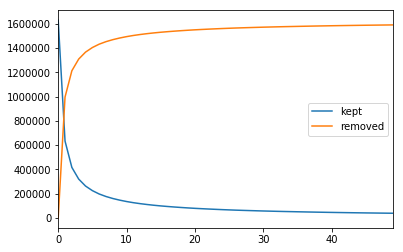

In [68]:
list_kept = []
list_removed = []
for x in range(0, 50):
    count_kept, count_removed = test_remove_threshold(x, unknown_words_e)
    list_kept.append(count_kept)
    list_removed.append(count_removed)
df = pd.DataFrame()
df["kept"] = list_kept
df["removed"] = list_removed
df.plot()


The above graph and the table below illustrate how a large number of very infrequent words exist in this corpus. Most of these actually only found once in all the documents. Likely some processing artefacts or other errors.

In [69]:
pd.set_option('display.max_rows', 50)
df

,kept,removed
0,1629104,0
1,633171,995933
2,416177,1212927
3,319974,1309130
4,262701,1366403
5,224953,1404151
6,197112,1431992
7,176390,1452714
8,159914,1469190
9,146435,1482669


I picked threshold of 30 to keep ~50k words and remove ~1.2M words / tokens. Well at the time of writing this anyway.. The size of the vocabulary easily multiplies the memory and processing requirements, so reasonable filtering seems useful.

In [70]:
words_to_remove = set()
words_to_check = []

#TODO: test threahold values

count = 0
count2 = 0
for word_count in reversed(unknown_words_e.most_common()):
    if word_count[1] > 30:
        #if more than N instances of word, do not remove but check later
        #TODO: smaller threshold for typo check?
        words_to_check.append(word_count)
        count2 += 1
        continue

    words_to_remove.add(word_count[0])    
    count += 1
print(f"selected {count} unknown words for removal")
print(f"kept {count2} unknown words")

def remove_infrequent_known_words():
    count = 0
    count2 = 0
    for word_count in reversed(known_words_e.most_common()):
        if word_count[1] > 2:
            #more than N instances of word, stop removing
            count2 += 1
            continue
        words_to_remove.add(word_count[0])
        count += 1
    print(f"selected {count} known words for removal")
    print(f"kept {count2} known words")


    
remove_infrequent_known_words()
    
words_to_check.sort(key=itemgetter(1), reverse=True)


selected 1571944 unknown words for removal
kept 57160 unknown words
selected 8454 known words for removal
kept 36939 known words


In [71]:
len(words_to_check)

57160

Remove all infrequent words:

In [72]:
size_before = 0
size_after = 0
new_list_list = []
for paragraph_list in tqdm(processed_nltk_paragraphs):
    new_list = []
    for paragraph in paragraph_list:
        size_before += len(paragraph)
        new_paragraph = [token for token in paragraph if token not in words_to_remove]
        size_after += len(new_paragraph)
        new_list.append(new_paragraph)
        del paragraph
    new_list_list.append(new_list)

del processed_nltk_paragraphs
processed_nltk_paragraphs = new_list_list
print(f"size before:{size_before}")
print(f"size after: {size_after}")
diff = size_before - size_after
print(f"reduced by: {diff}")
    


size before:103478347
size after: 99292336
reduced by: 4186011


### Find closest known words for unknown words

Find closest matching words from the collected known words for each word in the list of unknown words. I use the closest matchest to check for potential common typos. More frequent typos or same thing with slightly different typing (if not a real typo, e.g., British vs US English) are most useful for unifying.

Levenshtein allows calculating word distances, so if distance is 1 keep it in a list to see if it is a type and could be added to the "replacements" mapping.

In [73]:
!pip install weighted-levenshtein
!pip install python-Levenshtein

     |████████████████████████████████| 129 kB 4.7 MB/s 
  Created wheel for weighted-levenshtein: filename=weighted_levenshtein-0.2.1-cp36-cp36m-linux_x86_64.whl size=326162 sha256=1b251e6b3c51f91dddcc2494a54ec168ff667fc8336766d3502001685638f04f
  Stored in directory: /root/.cache/pip/wheels/10/fe/fe/28f5d0f363045c1c9fd4e9d69990cbda2ffe23a38cb1658ab7
Successfully built weighted-levenshtein


In [74]:
from weighted_levenshtein import lev, osa, dam_lev
import Levenshtein

#just to see it works
print(lev('BANANAS', 'BANDANAS'))
print(Levenshtein.distance("BANANAS", "BANDANAS"))

1.0
1


Perform the actual comparison unknwon vs all known words:

In [75]:
import time

def find_closest_matches(unknown_words, known_words):
    count = 0
    count_diff = 0
    count_short = 0
    count_scored = 0
    file_str = ""
    epoch_time = int(time.time()/60)
    for unknown in tqdm(unknown_words):
        if len(unknown[0]) < 5:
            count_short += 1
            #skip saving words that are shorter than 5 chars
            continue
#            if unknown[1] < 20:
#                #less than 10 instances of word, stop
#                break
        for known in known_words:
            unknown_word = unknown[0]
            known_word = known
            diff = len(unknown_word) - len(known_word)
            diff = abs(diff)
            if diff > 1:
                count_diff += 1
                continue
            count_scored += 1
            score = Levenshtein.distance(unknown_word, known_word)
            if score == 1:
                line = f"{unknown[1]}: '{unknown[0]}': '{known}',"
                file_str += f"{line}\n"
                if count < 50:
                    print(line)
                count += 1
    with open(f'output/closest.txt', 'w') as f:
        f.write(file_str)

    print(f"count={count}, count_diff={count_diff}, count_short={count_short}, count_scored={count_scored}")

In [76]:
find_closest_matches(words_to_check, known_words_e)
#find_closest_matches(unknown_words_e, known_words_e)


50604: 'cytokine': 'cytosine',
37951: 'andor': 'candor',
37951: 'andor': 'ardor',
32192: 'epitope': 'epitome',
25692: 'virion': 'vision',
22861: 'codon': 'colon',
22861: 'codon': 'coon',
22861: 'codon': 'cordon',
21978: 'realtime': 'mealtime',
20032: 'mucosal': 'mucosa',
19197: 'ebola': 'bola',
17481: 'germany': 'germane',
15024: 'murine': 'marine',
15024: 'murine': 'purine',
15024: 'murine': 'urine',
13611: 'tcell': 'tell',
13611: 'tcell': 'cell',
13245: 'adjuvant': 'adjutant',
11362: 'nterminal': 'terminal',
10923: 'cterminal': 'terminal',
9978: 'italy': 'ital',
9857: 'lectin': 'pectin',
9408: 'france': 'franc',
9408: 'france': 'trance',
8688: 'cytotoxin': 'cytotoxic',
8629: 'humoral': 'humeral',
8499: 'coinfection': 'confection',
8201: 'titre': 'title',
8201: 'titre': 'tire',
8201: 'titre': 'tithe',
7957: 'clade': 'blade',
7957: 'clade': 'clad',
7957: 'clade': 'glade',
7957: 'clade': 'lade',
7957: 'clade': 'clave',
7957: 'clade': 'clads',
7043: 'asian': 'avian',
6432: 'zhang': 'hang

In [77]:
!ls -l output

total 24304
-rw-r--r-- 1 root root   204778 Apr 25 10:26 closest.txt
-rw-r--r-- 1 root root 24679203 Apr 25 09:54 unknown.txt


In [78]:
url_counts.most_common(20)

[('https://doi.org/10.1101/2020.03.', 763),
 ('https://doi.org/10.', 704),
 ('https://doi.org/10.1101/2020.04.', 698),
 ('http://', 427),
 ('https://doi.org', 276),
 ('https://doi.org/10.1101/2020.02.', 230),
 ('http://www.', 210),
 ('https://', 112),
 ('https://doi.', 111),
 ('https://doi.org/10.1101/2020.04.14.', 87),
 ('https://doi.org/10.1101/19011940', 76),
 ('https://doi.org/10.1101/742320', 57),
 ('https://doi.org/10.1101/2020.04.13.20064519', 53),
 ('http://blast.ncbi.nlm.nih.gov/blast.cgi.', 50),
 ('http://www.ncbi.nlm.nih.gov', 50),
 ('http://www.ncbi.nlm.nih.gov/', 49),
 ('http://www.ncbi.nlm.nih.gov.', 47),
 ('http://blast.ncbi.nlm.nih.gov/blast.cgi', 45),
 ('https://doi.org/10.1101/338392', 44),
 ('https://doi.org/10.1101/2020.03.13.990598', 42)]

Here https://doi.org/10.1101/19011940 seems to be the top actual intact URL left. It refers to paper titled "Using Digital Surveillance Tools for Near Real-Time Mapping of the Risk of International Infectious Disease Spread: Ebola as a Case Study".

And thats all folks. You can just add this kernel as a data source if you like to play with the preprocessed files. Just click on "+Add data" on the right-side sidebar top if you like.

In [79]:
del words_to_check
del words_to_remove
del known_words_e
del unknown_words_e
del all_docs
del unknown_list
del unknown_str


Build the bigrams, trigrams, (and potentially quad-grams) with Gensim:

In [80]:
%%time
no_pool_gensim(filetypes, processed_nltk_paragraphs, filepaths, doc_ids)


creating bigram
creating trigram
creating bigram-model
creating trigram-model
processing docs


In [81]:
!ls output/paragraphs/custom_license | head -n 10

0003793cf9e709bc2b9d0c8111186f78fb73fc04.json
0005d253951fedc237715a37db147032eea28912.json
000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a.json
00154ef181732195c77fc1abd791fa2a996b9099.json
0016983545c217458b711d5aaad5fba583d81171.json
001916486b2012ccc611fe18d4763f9e81517cbb.json
001b8a3bcea5b3a810fd9d03a1bc51cf708fe399.json
001d8d54a7e73e761f779c81661595cc5ae2ca08.json
001ec025dd65db8a47827c8f49d9c41d60f35d00.json
0020ab317ef923b740c1d3db52083a4e48495f8a.json
ls: write error: Broken pipe


In [82]:
!du output


569888	output/paragraphs/comm_use_subset
132420	output/paragraphs/noncomm_use_subset
158668	output/paragraphs/biorxiv_medrxiv
1812704	output/paragraphs/custom_license
2673684	output/paragraphs
184680	output/whole/comm_use_subset
43192	output/whole/noncomm_use_subset
51060	output/whole/biorxiv_medrxiv
588548	output/whole/custom_license
867484	output/whole
3565476	output


See if the bigramming works:

In [83]:
#!head output/paragraphs/custom/00016663c74157a66b4d509d5c4edffd5391bbe0.json

# Package the output

In [84]:
!ls output

closest.txt  paragraphs  unknown.txt  whole


In [85]:
!ls output/paragraphs/noncomm_use_subset | wc -l

2102


In [86]:
!ls output/whole/noncomm_use_subset | wc -l

2102


In [87]:
!ls output/paragraphs/biorxiv_medrxiv | wc -l

2087


In [88]:
!ls -l output/whole/custom_license | head -n 10

total 586956
-rw-r--r-- 1 root root    4184 Apr 25 11:30 0003793cf9e709bc2b9d0c8111186f78fb73fc04.txt
-rw-r--r-- 1 root root    9787 Apr 25 11:24 0005d253951fedc237715a37db147032eea28912.txt
-rw-r--r-- 1 root root    8263 Apr 25 11:27 000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a.txt
-rw-r--r-- 1 root root   37467 Apr 25 11:30 00154ef181732195c77fc1abd791fa2a996b9099.txt
-rw-r--r-- 1 root root    4683 Apr 25 11:16 0016983545c217458b711d5aaad5fba583d81171.txt
-rw-r--r-- 1 root root   57065 Apr 25 11:23 001916486b2012ccc611fe18d4763f9e81517cbb.txt
-rw-r--r-- 1 root root  120059 Apr 25 11:13 001b8a3bcea5b3a810fd9d03a1bc51cf708fe399.txt
-rw-r--r-- 1 root root   28547 Apr 25 11:10 001d8d54a7e73e761f779c81661595cc5ae2ca08.txt
-rw-r--r-- 1 root root   20784 Apr 25 11:29 001ec025dd65db8a47827c8f49d9c41d60f35d00.txt
ls: write error: Broken pipe


In [89]:
!ls -l output/paragraphs/comm_use_subset | head -n 10


total 569352
-rw-r--r-- 1 root root   14311 Apr 25 11:32 00060fb61742ff60e4e3ba4648c74a34cfe9560d.json
-rw-r--r-- 1 root root   31468 Apr 25 11:23 001259ae6d9bfa9376894f61aa6b6c5f18be2177.json
-rw-r--r-- 1 root root   15875 Apr 25 11:22 0014b643b47d9b881e401ad5c4995622e0a39433.json
-rw-r--r-- 1 root root   20498 Apr 25 11:17 0015023cc06b5362d332b3baf348d11567ca2fbb.json
-rw-r--r-- 1 root root   26846 Apr 25 11:10 0017543a70b6b8d729f3bbd0a84f24683a1854d7.json
-rw-r--r-- 1 root root   68220 Apr 25 11:29 002160a433024de8c5e80b210f0b54e5d029fa57.json
-rw-r--r-- 1 root root   17565 Apr 25 11:26 002faa16056227423f9d108d01f0dae31491510c.json
-rw-r--r-- 1 root root   38549 Apr 25 11:16 00325033266973fb091b9beb535090bf94810283.json
-rw-r--r-- 1 root root   32864 Apr 25 11:22 00340eea543336d54adda18236424de6a5e91c9d.json
ls: write error: Broken pipe


In [90]:
#!head output/whole/comuse/1a465d982030d8f361dc914ff2defa359fdbe5f9.txt

In [91]:
!apt install zip -y




The following NEW packages will be installed:
  zip
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 234 kB of archives.
After this operation, 623 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian stretch/main amd64 zip amd64 3.0-11+b1 [234 kB]
Fetched 234 kB in 0s (3097 kB/s)
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package zip.
(Reading database ... 75022 files and directories currently installed.)
Preparing to unpack .../zip_3.0-11+b1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 16%] [#########.................................................] 8Unpacking zip (3.0-11+b1) ...
7Progress: [ 33%] [###################.......................................] 87Progress: [ 50%] [#############################.............................] 8Setting up zip (3.0-11+b1) ...
7Progress: [ 66%] [########

In [92]:
%%time
#!tar zcf output.tgz output


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [93]:
%%time
!zip -r -q output.zip output

CPU times: user 3.04 s, sys: 860 ms, total: 3.9 s
Wall time: 2min 7s


In [94]:
!ls -l output

total 24312
-rw-r--r-- 1 root root   204778 Apr 25 10:26 closest.txt
drwxr-xr-x 6 root root     4096 Apr 25 11:10 paragraphs
-rw-r--r-- 1 root root 24679203 Apr 25 09:54 unknown.txt
drwxr-xr-x 6 root root     4096 Apr 25 11:10 whole


In [95]:
!ls -l

total 601204
---------- 1 root root    449172 Apr 25 08:43 __notebook__.ipynb
drwxr-xr-x 4 root root      4096 Apr 25 11:10 output
-rw-r--r-- 1 root root 615171792 Apr 25 11:35 output.zip


In [96]:
!mkdir upload_dir
!mv output.zip upload_dir

In [97]:
!ls upload_dir

output.zip


In [98]:
os.path.abspath("./upload_dir")

'/kaggle/working/upload_dir'

In [99]:
import kaggle_uploader

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
api_secret = user_secrets.get_secret("kaggle api key")

kaggle_uploader.resources = []
kaggle_uploader.init_on_kaggle("donkeys", api_secret)
kaggle_uploader.base_path = "./upload_dir"
kaggle_uploader.title = "COVID NLP Preprocessed"
kaggle_uploader.dataset_id = "covid-nlp-preprocess"
kaggle_uploader.user_id = "donkeys"
kaggle_uploader.add_resource("output.zip", "zipped preprocessing data")
kaggle_uploader.update("new version")



/kaggle/working/upload_dir
running cmd:['kaggle', 'datasets', 'version', '-p', '/kaggle/working/upload_dir', '-m', '"new version"']
Starting upload for file output.zip
Upload successful: output.zip (587MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/donkeys/covid-nlp-preprocess



{'title': 'COVID NLP Preprocessed',
 'id': 'donkeys/covid-nlp-preprocess',
 'licenses': [{'name': 'CC0-1.0'}],
 'resources': [{'path': '/kaggle/working/upload_dir/output.zip',
   'description': 'zipped preprocessing data'}]}

Final check to see if missed some very common stopwords or such:

In [100]:
import collections

word_count = collections.Counter()
for doc in processed_nltk_paragraphs:
    for paragraph in doc:
        word_count.update(paragraph)
len(word_count)

94099

In [101]:
word_count.most_common(30)

[('cell', 850817),
 ('use', 767177),
 ('virus', 688792),
 ('infection', 546724),
 ('study', 498344),
 ('patient', 494973),
 ('protein', 463631),
 ('disease', 418528),
 ('viral', 311611),
 ('result', 288654),
 ('case', 285166),
 ('human', 264493),
 ('group', 239148),
 ('data', 236872),
 ('gene', 220714),
 ('time', 212132),
 ('response', 211051),
 ('level', 210510),
 ('sample', 210308),
 ('number', 203569),
 ('day', 202304),
 ('control', 194867),
 ('rna', 192865),
 ('health', 192504),
 ('mouse', 192494),
 ('antibody', 191288),
 ('analysis', 191140),
 ('clinical', 189660),
 ('system', 188003),
 ('treatment', 187665)]

Well, "use" is a bit of a give or take.. But I leave it in.

In [102]:
!ls output/paragraphs/biorxiv_medrxiv | head -n 10

0001418189999fea7f7cbe3e82703d71c85a6fe5.json
00016663c74157a66b4d509d5c4edffd5391bbe0.json
002c9e9bed0d874c169d9f77a135f12e41b733ee.json
01213acdd86020357259f2a1094bc43f9bb79796.json
0131ce11f9dbeac6ad5f732ab5d268674da53290.json
014fcb209d3870dce737d4d50e3ec85044cfd2f6.json
01626763ff19226d69dedacfe5fa22f2f0dd0018.json
018fb5e62fbbcae07d57d94d29ac630dcc4dccf9.json
019d4817c1bb20299f7bcd20248bd85ad0f59a2e.json
01b1b409f426cc712ba8e1876d0ac34bab8689e1.json
ls: write error: Broken pipe


In [103]:
!head output/paragraphs/biorxiv_medrxiv/00060fb61742ff60e4e3ba4648c74a34cfe9560d.json

head: cannot open 'output/paragraphs/biorxiv_medrxiv/00060fb61742ff60e4e3ba4648c74a34cfe9560d.json' for reading: No such file or directory


The output was zipped, so delete the directory with individual files. Kaggle notebooks seem to be unable to host 1000+ output files when used as input to other notebooks.

In [104]:
!rm -rf output